In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, roc_auc_score
from sklearn.feature_selection import RFE
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load the processed dataset
df_clean = pd.read_csv('churn_processed.csv')

# Separate features and target
X = df_clean.drop(['Exited', 'Geography_Spain'], axis=1)
y = df_clean['Exited']

# Split the data into training and test sets (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print(X_train.shape)
print(X_test.shape)

(7000, 13)
(3000, 13)


In [3]:
# Feature scaling - additional processing needed for regression models
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert to dataframe to keep column names
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns)


In [4]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data["feature"] = X_train_scaled_df.columns
vif_data["VIF"] = [variance_inflation_factor(X_train_scaled_df.values, i) for i in range(X_train_scaled_df.shape[1])]

print(vif_data.sort_values(by="VIF", ascending=False))


                 feature       VIF
12     Geography_Germany  1.731758
11      Geography_France  1.500502
5                Balance  1.331959
7       ComplaintsLodged  1.140145
6          NumOfProducts  1.120977
2                    Age  1.089322
9         IsActiveMember  1.039685
1                    Sex  1.010072
8              HasCrCard  1.002500
0            CreditScore  1.002464
4                 Tenure  1.002421
10       EstimatedSalary  1.001757
3   CurrentWorkingStatus  1.001496


In [6]:
# Explanation of hyperparameters:
# - C: Inverse of regularization strength; smaller values specify stronger regularization
# - penalty: L1 (Lasso) or L2 (Ridge) regularization
# - solver: Algorithm to use in the optimization problem
# - class_weight: Weights associated with classes (useful for imbalanced datasets)

# Define the parameter grid for Logistic Regression
param_grid = {
    'C': [ 1, 10, 100],  # Regularization parameter
    'penalty': ['l1', 'l2'],              # Regularization type (L1 or L2)
    'solver': ['liblinear', 'saga'],      # Algorithm to use
    'class_weight': [None, 'balanced']    # Class weights
}

In [7]:
# Create the GridSearchCV object
grid_search_lr = GridSearchCV(
    estimator=LogisticRegression(random_state=42, max_iter=1000),
    param_grid=param_grid,
    cv=5,                    # 5-fold cross-validation
    scoring='accuracy',      # Use accuracy as the scoring metric
    n_jobs=-1,               # Use all available CPU cores
    verbose=1                # Show progress
)

# Perform the grid search
print("Starting Grid Search for Logistic Regression optimization...")
grid_search_lr.fit(X_train_scaled, y_train)

Starting Grid Search for Logistic Regression optimization...
Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=1000, random_state=42),
             n_jobs=-1,
             param_grid={'C': [1, 10, 100], 'class_weight': [None, 'balanced'],
                         'penalty': ['l1', 'l2'],
                         'solver': ['liblinear', 'saga']},
             scoring='accuracy', verbose=1)

In [8]:
# Get the best parameters and best estimator
print("\nBest Parameters:")
print(grid_search_lr.best_params_)
print(grid_search_lr.get_params())


Best Parameters:
{'C': 1, 'class_weight': None, 'penalty': 'l1', 'solver': 'liblinear'}
{'cv': 5, 'error_score': nan, 'estimator__C': 1.0, 'estimator__class_weight': None, 'estimator__dual': False, 'estimator__fit_intercept': True, 'estimator__intercept_scaling': 1, 'estimator__l1_ratio': None, 'estimator__max_iter': 1000, 'estimator__multi_class': 'deprecated', 'estimator__n_jobs': None, 'estimator__penalty': 'l2', 'estimator__random_state': 42, 'estimator__solver': 'lbfgs', 'estimator__tol': 0.0001, 'estimator__verbose': 0, 'estimator__warm_start': False, 'estimator': LogisticRegression(max_iter=1000, random_state=42), 'n_jobs': -1, 'param_grid': {'C': [1, 10, 100], 'penalty': ['l1', 'l2'], 'solver': ['liblinear', 'saga'], 'class_weight': [None, 'balanced']}, 'pre_dispatch': '2*n_jobs', 'refit': True, 'return_train_score': False, 'scoring': 'accuracy', 'verbose': 1}


In [9]:
# Use the best model
lr_best = grid_search_lr.best_estimator_

# Evaluate on training and test sets
y_train_pred_lr = lr_best.predict(X_train_scaled)
y_test_pred_lr = lr_best.predict(X_test_scaled)

train_accuracy_lr = accuracy_score(y_train, y_train_pred_lr)
test_accuracy_lr = accuracy_score(y_test, y_test_pred_lr)

print("\nLogistic Regression Performance:")
print(f"Training Accuracy: {train_accuracy_lr:.4f}")
print(f"Test Accuracy: {test_accuracy_lr:.4f}")


Logistic Regression Performance:
Training Accuracy: 0.9703
Test Accuracy: 0.9660


In [10]:
# Check for overfitting
print("\nOverfitting Check:")
print(f"Accuracy difference (Train - Test): {train_accuracy_lr - test_accuracy_lr:.4f}")
if train_accuracy_lr - test_accuracy_lr > 0.05:
    print("Possible overfitting: Training accuracy is significantly higher than test accuracy")
else:
    print("No strong evidence of overfitting: Training and test accuracies are similar")



Overfitting Check:
Accuracy difference (Train - Test): 0.0043
No strong evidence of overfitting: Training and test accuracies are similar


In [11]:
# Get feature importances
feature_importances_lr = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': np.abs(lr_best.coef_[0])  # Taking absolute values for importance
}).sort_values('Coefficient', ascending=False)

print("\nFeature Importances (Top 10):")
print(feature_importances_lr.head(10))


Feature Importances (Top 10):
              Feature  Coefficient
7    ComplaintsLodged     2.694553
2                 Age     0.736761
9      IsActiveMember     0.433892
1                 Sex     0.380963
12  Geography_Germany     0.321544
10    EstimatedSalary     0.072881
11   Geography_France     0.057028
5             Balance     0.043982
0         CreditScore     0.036612
4              Tenure     0.034878


In [12]:
# Print model details
print("\nRegression Model Details:")
print(f"Regression function: Logistic Regression")
print(f"Regularization type: {lr_best.penalty}")
print(f"Regularization strength (C): {lr_best.C}")
print(f"Solver: {lr_best.solver}")
print(f"Class weights: {lr_best.class_weight}")

# Included variables
print("\nVariables included in the model:")
for feature in X_train.columns:
    print(f"- {feature}")


Regression Model Details:
Regression function: Logistic Regression
Regularization type: l1
Regularization strength (C): 1
Solver: liblinear
Class weights: None

Variables included in the model:
- CreditScore
- Sex
- Age
- CurrentWorkingStatus
- Tenure
- Balance
- NumOfProducts
- ComplaintsLodged
- HasCrCard
- IsActiveMember
- EstimatedSalary
- Geography_France
- Geography_Germany


In [13]:
# First, let's get the top 5 features from the full regression model
top_regression_features = feature_importances_lr['Feature'].head(5).tolist()
print("\nTop 5 features from full regression model:")
print(top_regression_features)


Top 5 features from full regression model:
['ComplaintsLodged', 'Age', 'IsActiveMember', 'Sex', 'Geography_Germany']


In [14]:
# Create a reduced dataset with only these top regression features
X_train_reduced = X_train_scaled_df[top_regression_features]
X_test_reduced = X_test_scaled_df[top_regression_features]

In [15]:
# Define the parameter grid for the reduced model
param_grid_reduced = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga'],
    'class_weight': [None, 'balanced']
}

In [16]:
# Create the GridSearchCV object for the reduced model
grid_search_lr_reduced = GridSearchCV(
    estimator=LogisticRegression(random_state=42, max_iter=1000),
    param_grid=param_grid_reduced,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

In [17]:
# Perform the grid search on the reduced feature set
print("\nStarting Grid Search for reduced Logistic Regression model...")
grid_search_lr_reduced.fit(X_train_reduced, y_train)

# Get the best parameters and best estimator for the reduced model
print("\nBest Parameters for reduced model:")
print(grid_search_lr_reduced.best_params_)


Starting Grid Search for reduced Logistic Regression model...
Fitting 5 folds for each of 48 candidates, totalling 240 fits

Best Parameters for reduced model:
{'C': 0.001, 'class_weight': None, 'penalty': 'l1', 'solver': 'liblinear'}


In [18]:
# Use the best reduced model
lr_reduced_best = grid_search_lr_reduced.best_estimator_

# Evaluate the reduced model on training and test sets
y_train_pred_lr_reduced = lr_reduced_best.predict(X_train_reduced)
y_test_pred_lr_reduced = lr_reduced_best.predict(X_test_reduced)

train_accuracy_lr_reduced = accuracy_score(y_train, y_train_pred_lr_reduced)
test_accuracy_lr_reduced = accuracy_score(y_test, y_test_pred_lr_reduced)

print("\nReduced Logistic Regression Performance:")
print(f"Training Accuracy: {train_accuracy_lr_reduced:.4f}")
print(f"Test Accuracy: {test_accuracy_lr_reduced:.4f}")


Reduced Logistic Regression Performance:
Training Accuracy: 0.9704
Test Accuracy: 0.9660


In [19]:
# Check for overfitting in the reduced model
print("\nOverfitting Check for reduced model:")
print(f"Accuracy difference (Train - Test): {train_accuracy_lr_reduced - test_accuracy_lr_reduced:.4f}")
if train_accuracy_lr_reduced - test_accuracy_lr_reduced > 0.05:
    print("Possible overfitting: Training accuracy is significantly higher than test accuracy")
else:
    print("No strong evidence of overfitting: Training and test accuracies are similar")


Overfitting Check for reduced model:
Accuracy difference (Train - Test): 0.0044
No strong evidence of overfitting: Training and test accuracies are similar


In [20]:
# Get feature importances for the reduced model
feature_importances_lr_reduced = pd.DataFrame({
    'Feature': X_train_reduced.columns,
    'Coefficient': np.abs(lr_reduced_best.coef_[0])
}).sort_values('Coefficient', ascending=False)

print("\nFeature Importances for reduced model:")
print(feature_importances_lr_reduced)


Feature Importances for reduced model:
             Feature  Coefficient
0   ComplaintsLodged     1.021915
1                Age     0.000000
2     IsActiveMember     0.000000
3                Sex     0.000000
4  Geography_Germany     0.000000


In [21]:
# Calculate prediction probabilities
y_train_proba_full = lr_best.predict_proba(X_train_scaled)[:, 1]
y_test_proba_full = lr_best.predict_proba(X_test_scaled)[:, 1]
y_train_proba_reduced = lr_reduced_best.predict_proba(X_train_reduced)[:, 1]
y_test_proba_reduced = lr_reduced_best.predict_proba(X_test_reduced)[:, 1]

# Calculate ROC curve and AUC for both models (test set)
fpr_full, tpr_full, _ = roc_curve(y_test, y_test_proba_full)
fpr_reduced, tpr_reduced, _ = roc_curve(y_test, y_test_proba_reduced)
auc_full = auc(fpr_full, tpr_full)
auc_reduced = auc(fpr_reduced, tpr_reduced)

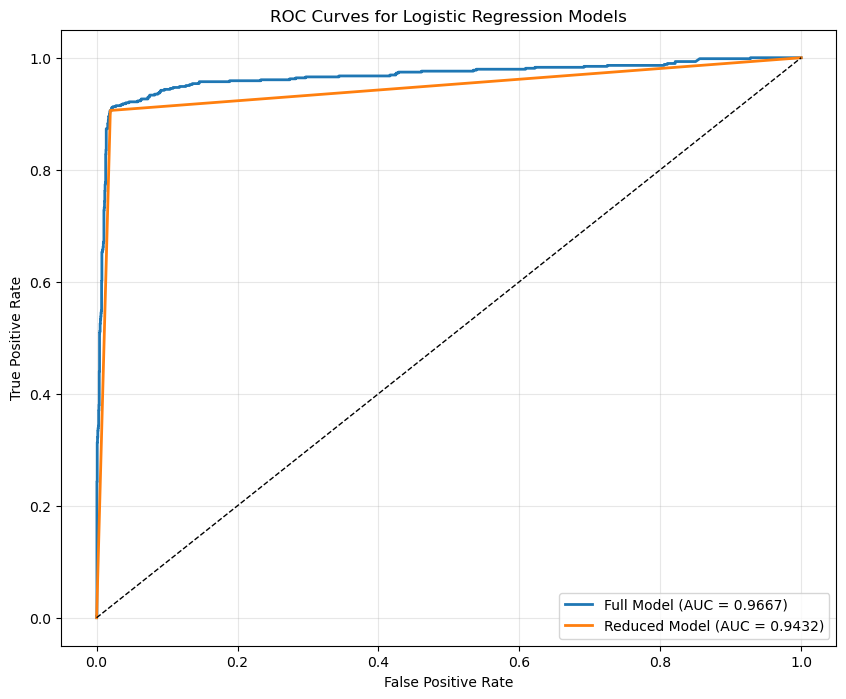

In [22]:
# Plot ROC curves for both models
plt.figure(figsize=(10, 8))
plt.plot(fpr_full, tpr_full, label=f'Full Model (AUC = {auc_full:.4f})', linewidth=2)
plt.plot(fpr_reduced, tpr_reduced, label=f'Reduced Model (AUC = {auc_reduced:.4f})', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', linewidth=1)  # Diagonal line for reference
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Logistic Regression Models')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.show()

In [23]:
# Compare both models
print("\nModel Comparison:")
print(f"Full model test accuracy: {test_accuracy_lr:.4f}")
print(f"Reduced model test accuracy: {test_accuracy_lr_reduced:.4f}")
print(f"Full model AUC: {auc_full:.4f}")
print(f"Reduced model AUC: {auc_reduced:.4f}")


Model Comparison:
Full model test accuracy: 0.9660
Reduced model test accuracy: 0.9660
Full model AUC: 0.9667
Reduced model AUC: 0.9432


In [24]:
# Determine the best model
best_model = "Full" if test_accuracy_lr >= test_accuracy_lr_reduced else "Reduced"
print(f"\nBest performing model based on test accuracy: {best_model} model")

# Provide characteristics of customers likely to churn based on the best model
print("\nCharacteristics of customers most likely to exit (based on feature importance):")
best_importances = feature_importances_lr if best_model == "Full" else feature_importances_lr_reduced
for i, (feature, importance) in enumerate(zip(best_importances['Feature'].head(5), best_importances['Coefficient'].head(5))):
    print(f"{i+1}. {feature}: Coefficient = {importance:.4f}")


Best performing model based on test accuracy: Full model

Characteristics of customers most likely to exit (based on feature importance):
1. ComplaintsLodged: Coefficient = 2.6946
2. Age: Coefficient = 0.7368
3. IsActiveMember: Coefficient = 0.4339
4. Sex: Coefficient = 0.3810
5. Geography_Germany: Coefficient = 0.3215


In [25]:
# Analyze the coefficients to understand their impact
print("\nImpact of key features on churn probability:")
if best_model == "Full":
    for feature, coef in zip(X_train.columns, lr_best.coef_[0]):
        print(f"- {feature}: {coef:.4f} {'increases' if coef > 0 else 'decreases'} churn probability")
else:
    for feature, coef in zip(X_train_reduced_final.columns, lr_reduced_best.coef_[0]):
        print(f"- {feature}: {coef:.4f} {'increases' if coef > 0 else 'decreases'} churn probability")


Impact of key features on churn probability:
- CreditScore: -0.0366 decreases churn probability
- Sex: 0.3810 increases churn probability
- Age: 0.7368 increases churn probability
- CurrentWorkingStatus: 0.0135 increases churn probability
- Tenure: -0.0349 decreases churn probability
- Balance: 0.0440 increases churn probability
- NumOfProducts: -0.0089 decreases churn probability
- ComplaintsLodged: 2.6946 increases churn probability
- HasCrCard: -0.0212 decreases churn probability
- IsActiveMember: -0.4339 decreases churn probability
- EstimatedSalary: -0.0729 decreases churn probability
- Geography_France: -0.0570 decreases churn probability
- Geography_Germany: 0.3215 increases churn probability


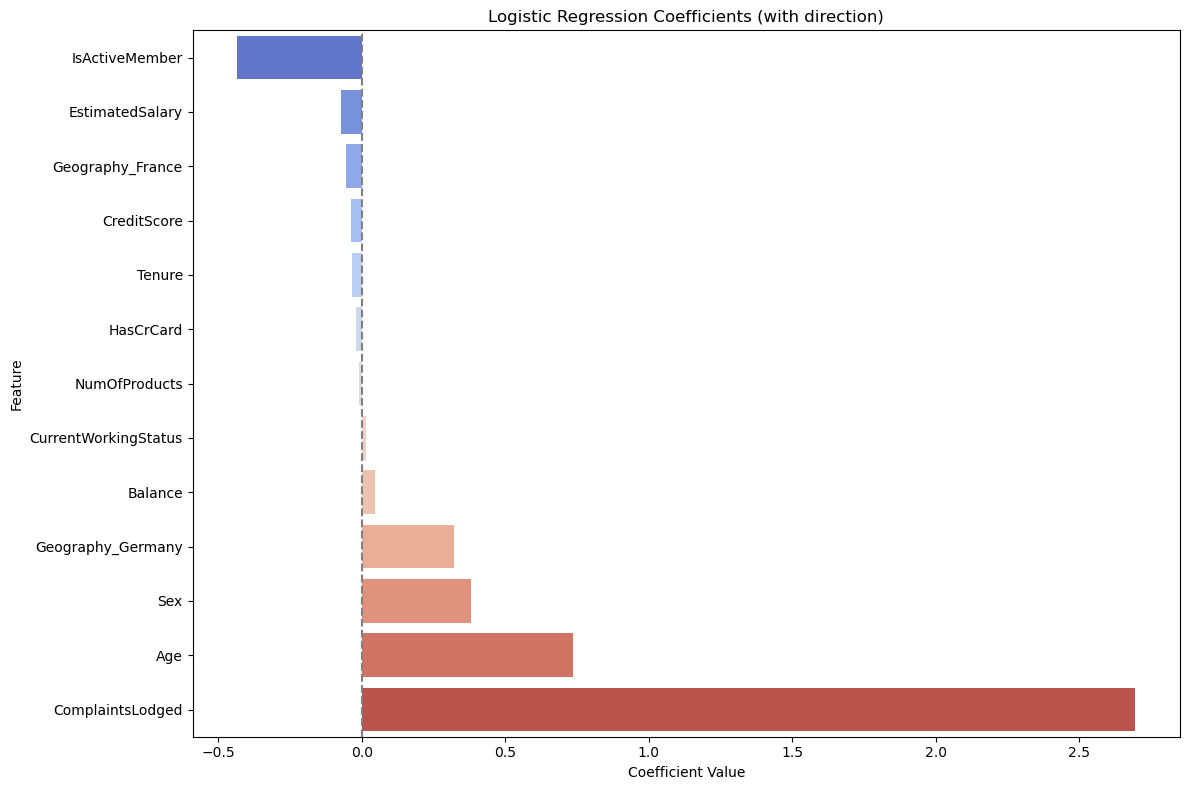

In [26]:
# Visualize feature coefficients with direction (not just magnitude)
plt.figure(figsize=(12, 8))
# Get coefficients with signs
coef_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': lr_best.coef_[0]
}).sort_values('Coefficient')
# Plot horizontal bar chart
sns.barplot(x='Coefficient', y='Feature', data=coef_df, palette='coolwarm')
plt.axvline(x=0, color='gray', linestyle='--')
plt.title('Logistic Regression Coefficients (with direction)')
plt.xlabel('Coefficient Value')
plt.tight_layout()
plt.show()

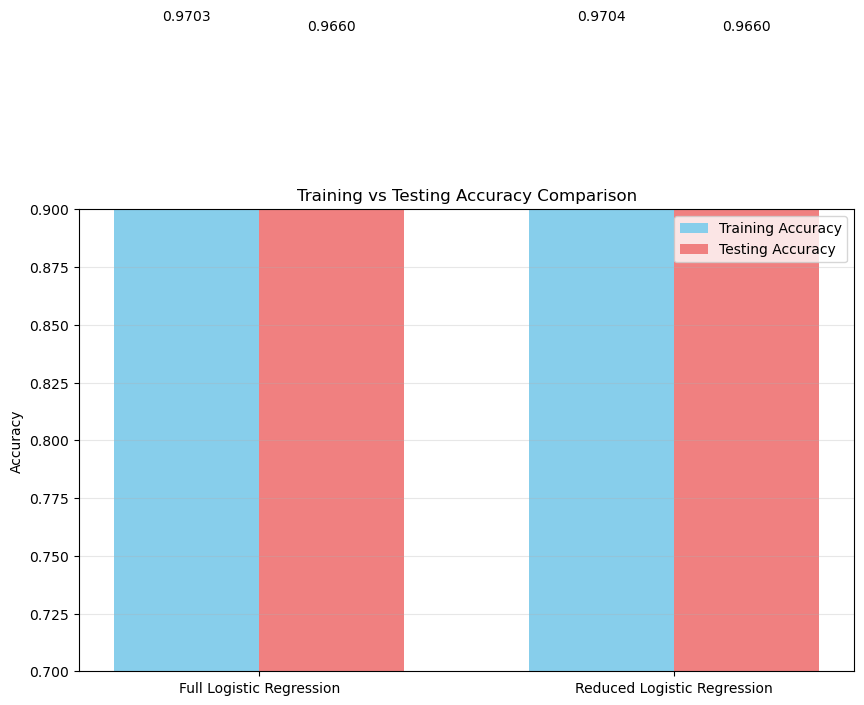

In [27]:
# Visualize training vs testing accuracy comparison
models = ['Full Logistic Regression', 'Reduced Logistic Regression']
train_accuracies = [train_accuracy_lr, train_accuracy_lr_reduced]
test_accuracies = [test_accuracy_lr, test_accuracy_lr_reduced]

plt.figure(figsize=(10, 6))
x = np.arange(len(models))
width = 0.35

plt.bar(x - width/2, train_accuracies, width, label='Training Accuracy', color='skyblue')
plt.bar(x + width/2, test_accuracies, width, label='Testing Accuracy', color='lightcoral')

# Add accuracy values on bars
for i, v in enumerate(train_accuracies):
    plt.text(i - width/2, v + 0.01, f'{v:.4f}', ha='center', va='bottom')
    
for i, v in enumerate(test_accuracies):
    plt.text(i + width/2, v + 0.01, f'{v:.4f}', ha='center', va='bottom')

plt.ylabel('Accuracy')
plt.title('Training vs Testing Accuracy Comparison')
plt.xticks(x, models)
plt.ylim(0.7, 0.9)
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.show()

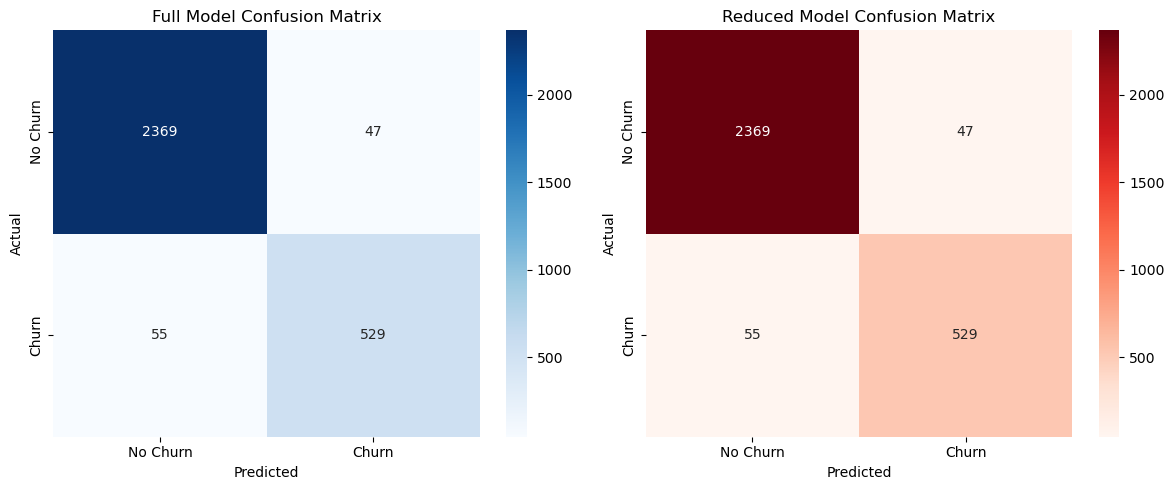

In [28]:
# Create confusion matrices for visual comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Full model confusion matrix
cm1 = confusion_matrix(y_test, y_test_pred_lr)
sns.heatmap(cm1, annot=True, fmt='d', cmap='Blues', ax=ax1)
ax1.set_title('Full Model Confusion Matrix')
ax1.set_xlabel('Predicted')
ax1.set_ylabel('Actual')
ax1.set_xticklabels(['No Churn', 'Churn'])
ax1.set_yticklabels(['No Churn', 'Churn'])

# Reduced model confusion matrix
cm2 = confusion_matrix(y_test, y_test_pred_lr_reduced)
sns.heatmap(cm2, annot=True, fmt='d', cmap='Reds', ax=ax2)
ax2.set_title('Reduced Model Confusion Matrix')
ax2.set_xlabel('Predicted')
ax2.set_ylabel('Actual')
ax2.set_xticklabels(['No Churn', 'Churn'])
ax2.set_yticklabels(['No Churn', 'Churn'])

plt.tight_layout()
plt.show()


Classification Report - Full Logistic Regression Model:
              precision    recall  f1-score   support

    No Churn       0.98      0.98      0.98      2416
       Churn       0.92      0.91      0.91       584

    accuracy                           0.97      3000
   macro avg       0.95      0.94      0.95      3000
weighted avg       0.97      0.97      0.97      3000


Classification Report - Reduced Logistic Regression Model:
              precision    recall  f1-score   support

    No Churn       0.98      0.98      0.98      2416
       Churn       0.92      0.91      0.91       584

    accuracy                           0.97      3000
   macro avg       0.95      0.94      0.95      3000
weighted avg       0.97      0.97      0.97      3000



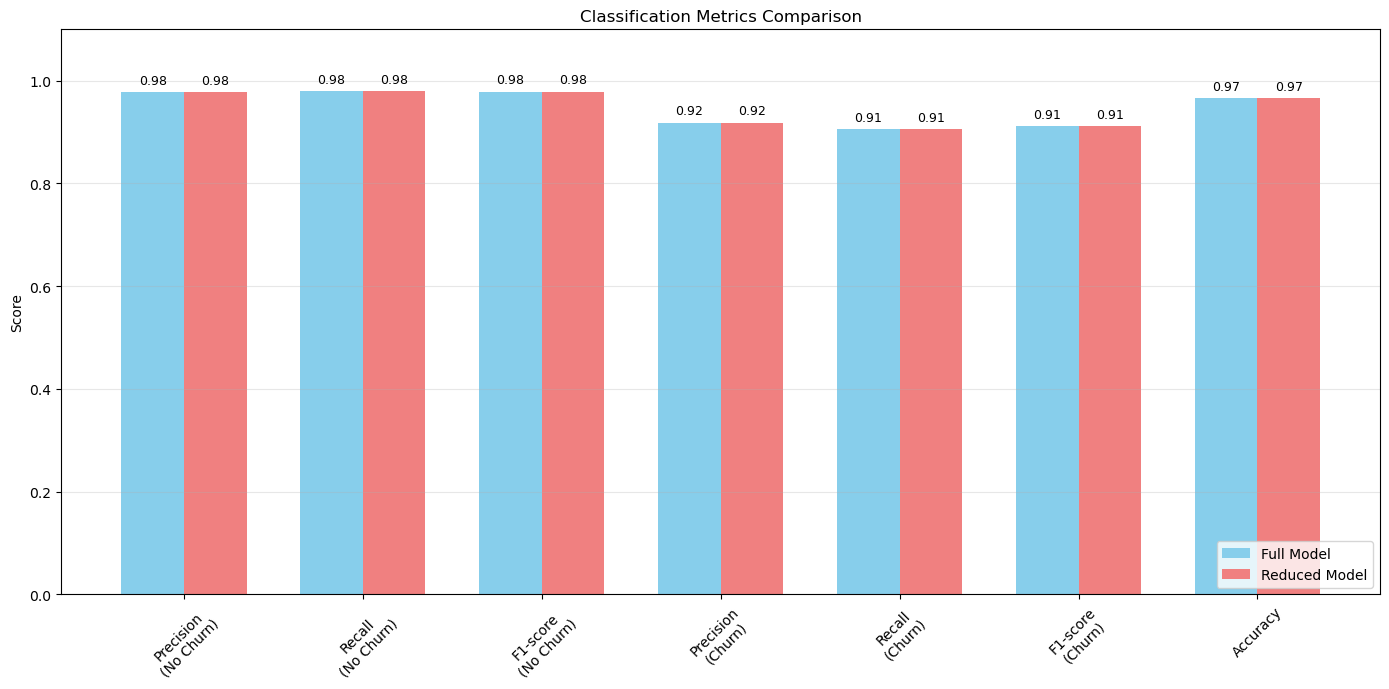

In [29]:
# Generate classification reports for both models
from sklearn.metrics import classification_report

# Full model classification report
print("\nClassification Report - Full Logistic Regression Model:")
print(classification_report(y_test, y_test_pred_lr, target_names=['No Churn', 'Churn']))

# Reduced model classification report
print("\nClassification Report - Reduced Logistic Regression Model:")
print(classification_report(y_test, y_test_pred_lr_reduced, target_names=['No Churn', 'Churn']))

# Extract classification metrics for visualization
def get_metrics_from_report(y_true, y_pred):
    report = classification_report(y_true, y_pred, output_dict=True)
    precision_0 = report['0']['precision']
    recall_0 = report['0']['recall']
    f1_0 = report['0']['f1-score']
    precision_1 = report['1']['precision']
    recall_1 = report['1']['recall']
    f1_1 = report['1']['f1-score']
    accuracy = report['accuracy']
    return [precision_0, recall_0, f1_0, precision_1, recall_1, f1_1, accuracy]

# Get metrics for both models
metrics_full = get_metrics_from_report(y_test, y_test_pred_lr)
metrics_reduced = get_metrics_from_report(y_test, y_test_pred_lr_reduced)

# Create a metrics comparison chart
metrics_names = ['Precision\n(No Churn)', 'Recall\n(No Churn)', 'F1-score\n(No Churn)', 
                'Precision\n(Churn)', 'Recall\n(Churn)', 'F1-score\n(Churn)', 'Accuracy']

plt.figure(figsize=(14, 7))
x = np.arange(len(metrics_names))
width = 0.35

plt.bar(x - width/2, metrics_full, width, label='Full Model', color='skyblue')
plt.bar(x + width/2, metrics_reduced, width, label='Reduced Model', color='lightcoral')

# Add values on top of bars
for i, v in enumerate(metrics_full):
    plt.text(i - width/2, v + 0.01, f'{v:.2f}', ha='center', va='bottom', fontsize=9)
    
for i, v in enumerate(metrics_reduced):
    plt.text(i + width/2, v + 0.01, f'{v:.2f}', ha='center', va='bottom', fontsize=9)

plt.ylabel('Score')
plt.title('Classification Metrics Comparison')
plt.xticks(x, metrics_names, rotation=45)
plt.ylim(0, 1.1)
plt.legend(loc='lower right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()